# Inside Airbnb Oslo (CRISP-DM)

## Table of Contents
[Business Understanding](#business-understanding)
* [About Airbnb](#about-airbnb)
* [Business questions](#business)
* [CRISP-DM](#crisp-dm)
* [Assumptions](#assumptions)

[Data Understanding Part 1](#data-understanding1)
* [Gather data](#gather-data)
* [Assess data](#assess-data)

[Data Preparation](#data-preparation)
* [Data cleaning approach](#data-cleaning)
* [Clean data](#clean-data)

[Data Understanding Part 2](#data-understanding2)
* [Exploration](#exploration)
* [What data is required to answer our questions?](#what-data)

[Modeling](#modeling)
* [OLS](#ols)

[Evaluation](#evaluation)
* [Evaluate results](#evaluate-results)
* [Determine next steps](#next-steps)

[References](#references)

## Business Understanding <a class="anchor" id="business-understanding"></a>

### About Airbnb <a class="anchor" id="about-airbnb"></a>

Airbnb was founded in 2008 in San Francisco, California and provides an online marketplace for accommodation, primarily homestays. It has become hugely popular during the 2010s and has made it easy for ordinary people to rent out their home or other property.

### Business questions <a class="anchor" id="business"></a>

Our focus area will be the city of Oslo - the capital of Norway - and we have identified the following business questions. 

> Question 1: How do Airbnb prices in Oslo vary throughout the year? Any trends / seasonality observed?

> Question 2: Which are the most expensive neighbourhoods, when calculated per guest?

> Question 3: In which neighbourhoods do guests feel like they got good value for their money?

> Question 4: What are the top predictors of price?

### CRISP-DM <a class="anchor" id="crisp-dm"></a>

To help organize our work in this notebook we are following the Cross-industry standard process for data mining (CRISP-DM), which is an open standard process model that describes common approaches used by data mining experts.

There are 6 major phases in this process:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

Each of these phases are present in the Table of Contents.

### Assumptions <a class="anchor" id="assumptions"></a>

1. We assume that the quality of the data is good enough for our analysis and modeling.

The data is gathered from Inside Airbnb (http://insideairbnb.com/), which is a free source, and it is from real listings on the date 2019-11-29. It would have been even better to have access to Airbnb's API, which I assume would contain transactional historic data, but that requires Airbnb to approve your corporation and it comes at a cost. That is not feasible for this project.

2. Even though the price data is given as USD, we assume that the currency is actually NOK. 

This seems much more plausible; otherwise an average Airbnb night would be five times that of a typical hotel room (the USDNOK exchange ratio on 2019-11-29 was around 9.2)

3. We assume that the prices in the calendar give a good indication of the actual price levels in the coming 12 months.

## Data Understanding Part 1<a class="anchor" id="data-understanding1"></a>

Eventually we need to understand what data is necessary to answer our business related questions.

But there is a lot to do before we can do that. 

First we need to wrangle our data; gather it, assess it and clean it. In the process of doing do, we will gain some general understanding of the data, which is our aim in the Data Understanding Part 1 chapter.

### Gather data <a class="anchor" id="gather-data"></a>

In [163]:
# IMPORTING LIBRARIES

# pandas and numpy
import pandas as pd
import numpy as np

# file management
import requests
import os

# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
base_color = sns.color_palette()[0]

# regex
import re

# geopandas
import geopandas as gpd
import descartes

# modeling w/scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# evaluating colinearity among variables
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor

# jupyter notebook rending
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

We will programmatically download files from http://insideairbnb.com/.

First we create a folder for the data files locally.

In [2]:
folder_name = 'data'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

**File 1**: "calendar.csv.gz" 

    a. Again we utilize the requests library to store the response from the server.

In [3]:
url = 'http://data.insideairbnb.com/norway/oslo/oslo/2019-11-29/data/calendar.csv.gz'
response = requests.get(url)
response

<Response [200]>

Response code 200 means our request was successful and the server responded with the data we were requesting. Great!

    b. We write the data to a file in our data folder

In [4]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

**File 2:** "neighbourhoods.geojson"

    a. We utilize the requests library to store the response from the server.

In [5]:
url = 'http://data.insideairbnb.com/norway/oslo/oslo/2019-11-29/visualisations/neighbourhoods.geojson'
response = requests.get(url)
response

<Response [200]>

Response code 200 means our request was successful and the server responded with the data we were requesting.

    b. We write the data to a file in our data folder

In [6]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

**File 3:** "listings.csv"

    a. Again we utilize the requests library to store the response from the server.

In [7]:
url = 'http://data.insideairbnb.com/norway/oslo/oslo/2019-11-29/data/listings.csv'
response = requests.get(url)
response

<Response [200]>

Response code 200 means our request was successful and the server responded with the data we were requesting.

    b. We write the data to a file in our data folder

In [8]:
with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)

**All the files:** We verify our files are available in our folder

In [9]:
os.listdir(folder_name)

['calendar.csv.gz', 'listings.csv', 'neighbourhoods.geojson']

Indeed they are. Nice!

**Reading the files into Pandas DataFrames**

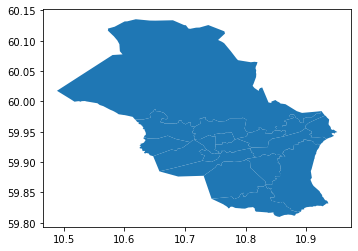

In [10]:
df_geo_raw = gpd.read_file('./data/neighbourhoods.geojson')
df_geo_raw.plot();

In [11]:
df_raw = pd.read_csv('./data/listings.csv', parse_dates=['last_review'])
df_raw.head(3)

C:\Anaconda3\envs\dand\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42932,https://www.airbnb.com/rooms/42932,20191129104559,2019-11-29,"Charming apartment, Oslo Center, Ro",NaN,"Charming apartment, Oslo Center, Royal House T...","Charming apartment, Oslo Center, Royal House T...",none,(URL HIDDEN),NaN,NaN,The whole flat,I will be on phone or mail 24/7 during you sta...,Comment sense :),NaN,NaN,https://a0.muscache.com/im/pictures/e84133b1-2...,NaN,187463,https://www.airbnb.com/users/show/187463,Cecilie,2010-08-01,"Oslo, Oslo, Norway","Fashion clothing designer,Concept developer 47...",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/187463/profil...,https://a0.muscache.com/im/users/187463/profil...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Oslo, Oslo, Norway",Frogner,Frogner,NaN,Oslo,Oslo,0253,Oslo,"Oslo, Norway",NO,Norway,59.91234,10.72384,...,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",NaN,"$2,000.00","$10,000.00","$25,000.00",$0.00,$300.00,3,$0.00,3,300,3,3,300,300,3.0,300.0,6 months ago,t,28,55,85,360,2019-11-29,37,7,2013-09-02,2019-06-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,1,1,0,0,0.49
1,43198,https://www.airbnb.com/rooms/43198,20191129104559,2019-11-29,Lovely low budgetroom in nice area!,"This is a small, bright room, facing our quiet...","A beautiful intimate bedroom, in an appartment...","This is a small, bright room, facing our quiet...",none,Only five minutes walk from the castle and the...,I would prefer one person but can accept two. ...,"Walking Oslo is quiet possible, really lovely,...",Shared bathroom and well equipped kitchen. Wi-fi.,You will have full privacy.,"This is our home, and we will respect your pri...",NaN,NaN,https://a0.muscache.com/im/pictures/73523d9a-a...,NaN,4011871,https://www.airbnb.com/users/show/4011871,Mona Johanne,2012-10-30,"Oslo, Oslo, Norway","We offer a beautiful, spacious room with high ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/4011871/profi...,https://a0.muscache.com/im/users/4011871/profi...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,f,"Oslo, Oslo, Norway",Frogner,Frogner,NaN,Oslo,Oslo,0263,Oslo,"Oslo, Norway",NO,Norway,59.91839,10.71457,...,1.0,Real Bed,"{Wifi,Kitchen,""Pets live on this property"",Cat...",NaN,$385.00,NaN,NaN,$0.00,$101.00,1,$101.00,2,4,2,2,4,4,2.0,4.0,4 months ago,t,0,0,0,0,2019-11-29,3

In [12]:
df_cal_raw = pd.read_csv('./data/calendar.csv.gz', compression='gzip')
df_cal_raw.head(3)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13612597,2019-11-29,f,$505.00,$505.00,1,6
1,13612597,2019-11-30,f,$505.00,$505.00,1,6
2,13612597,2019-12-01,f,$505.00,$505.00,1,6


The data have been successfully read into dataframes.

We make copies for further work, while keeping the raw data as well.

In [13]:
df_geo = df_geo_raw.copy()

In [14]:
df = df_raw.copy()

In [15]:
df_cal = df_cal_raw.copy()

### Assess data <a class="anchor" id="assess-data"></a>

First we look at `df_geo`

In [221]:
df_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 2 columns):
neighbourhood    17 non-null object
geometry         17 non-null geometry
dtypes: geometry(1), object(1)
memory usage: 400.0+ bytes


We can see that `df_geo` is a geopandas 'GeoDataFrame'.

There are 17 entries.

Column 'neighbourhood_group' only contains null values.

In [19]:
df_geo

,neighbourhood,neighbourhood_group,geometry
0,Bjerke,None,"MULTIPOLYGON (((10.78661 59.93823, 10.78860 59..."
1,Frogner,None,"MULTIPOLYGON (((10.64777 59.90941, 10.67810 59..."
2,Sagene,None,"MULTIPOLYGON (((10.74832 59.94551, 10.75929 59..."
3,Vestre Aker,None,"MULTIPOLYGON (((10.61789 59.96986, 10.62984 59..."
4,Sentrum,None,"MULTIPOLYGON (((10.72282 59.91716, 10.72855 59..."
5,Grorud,None,"MULTIPOLYGON (((10.84833 59.95676, 10.85042 59..."
6,St. Hanshaugen,None,"MULTIPOLYGON (((10.71574 59.93626, 10.72009 59..."
7,Nordre Aker,None,"MULTIPOLYGON (((10.71207 59.94769, 10.71236 59..."
8,Grünerløkka,None,"MULTIPOLYGON (((10.74873 59.92033, 10.75124 59..."
9,Gamle Oslo,None,"MULTIPOLYGON (((10.65808 59.88441, 10.68243 59..."


The 'geometry' column contains multipolygon coordinates, ie. the coordinates necessary to draw the shape of each neighbourhood and form some sort of map of Oslo.

Next we look at `df`, which is our "main" DataFrame containing listings data

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8604 entries, 0 to 8603
Columns: 106 entries, id to reviews_per_month
dtypes: datetime64[ns](1), float64(25), int64(21), object(59)
memory usage: 7.0+ MB


There are 8,604 entries and 106 columns.

One column has data type 'datetime', and there are 25 float, 21 int and 59 string.

Let's look at the one with **date_time**:

In [21]:
df.describe(include='datetime')

,last_review
count,6829
unique,1222
top,2019-11-24 00:00:00
freq,143
first,2013-05-18 00:00:00
last,2019-11-29 00:00:00


This gives a indication of time range: May 2013 - November 2019 (based on the 'last_review' values). However, note that the listings data in `df` is a snapshot from 2019-11-29, which means we do not really have historic data in this dataset.

We look at the description of **numeric** variables. As we know, there are many; 25 float and 21 integer.

In [22]:
df.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.604000e+03,8.604000e+03,0.0,0.0,0.0,8.604000e+03,0.0,8597.000000,8597.000000,0.0,8604.000000,8604.000000,8604.000000,8601.000000,8599.000000,8590.000000,50.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,8604.000000,6653.000000,6647.000000,6650.000000,6637.000000,6645.000000,6635.000000,6634.000000,0.0,0.0,8604.000000,8604.000000,8604.000000,8604.000000,6829.000000
mean,2.086794e+07,2.019113e+13,NaN,NaN,NaN,7.021649e+07,NaN,1.715947,1.715947,NaN,59.921652,10.756251,3.259995,1.094873,1.413885,1.904424,462.820000,1.459205,4.265690,608.380637,4.228266,4.601232,618.064389,620.837169,4.375732,619.770456,4.892724,11.507322,18.826709,58.849489,17.740586,6.042655,95.662408,9.749812,9.522256,9.769776,9.843642,9.697212,9.596473,NaN,NaN,1.643422,1.231288,0.354021,0.045560,1.063601
std,1.079553e+07,0.000000e+00,NaN,NaN,NaN,7.127228e+07,NaN,2.733305,2.733305,NaN,0.018291,0.038040,1.660944,0.313659,0.880904,1.334956,365.170672,0.905938,18.370528,555.254874,18.358037,21.225646,554.791703,554.485816,18.947351,554.154858,8.896253,18.920865,29.939108,105.173598,41.280674,13.862627,6.419184,0.663404,0.874877,0.646106,0.563882,0.597792,0.722739,NaN,NaN,2.674743,2.491686,1.036790,0.566833,1.534374
min,4.293200e+04,2.019113e+13,NaN,NaN,NaN,2.755400e+04,NaN,0.000000,0.000000,NaN,59.818150,10.623810,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.290353e+07,2.019113e+13,NaN,NaN,NaN,1.735203e+07,NaN,1.000000,1.000000,NaN,59.913938,10.734578,2.000000,1.000000,1.000000,1.000000,79.500000,1.000000,2.000000,20.000000,2.000000,2.000000,21.000000,21.000000,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,94.000000,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.170000
50%,1.981846e+07,2.019113e+13,NaN,NaN,NaN,4.498351e+07,NaN,1.000000,1.000000,NaN,59.922875,10.760690,3.000000,1.000000,1.000000,2.000000,538.000000,1.000000,2.000000,1125.000000,2.000000,2.000000,1125.000000,1125.000000,2.000000,1125.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.470000
75%,2.985227e+07,2.019113e+13,NaN,NaN,NaN,9.627341e+07,NaN,2.000000,2.000000,NaN,59.930170,10.774213,4.000000,1.000000,2.000000,2.000000,686.500000,2.000000,3.000000,1125.000000,3.000000,4.000000,1125.000000,1125.000000,3.100000,1125.000000,6.000000,19.000000,29.000000,70.000000,16.000000,5.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,1.000000,1.000000,0.000000,0.000000,1.250000
max,4.044807e+07,2.019113e+13,NaN,NaN,NaN,3.125356e+08,NaN,41.000000,41.000000,NaN,60.036680,10.944150,16.000000,5.500000,9.000000,16.000

Some notes on min/max ranges (inclusive): 
- 'host_listings_count' ranges from 0 to 41. (mean: 1.73)
- 'accommodates' from 1 to 16. (mean: 3.25)
- 'bathrooms' from 0 to 5.5. (mean: 1.09)
- 'bedrooms' from 0 to 9. (mean: 1.41)
- 'beds' from 0 to 16. (mean: 1.89)
- 'square_feet' from 0 to 1238 (mean: 463)  <- Only 50 non-na occurrences listed. However, there could be more square foot data hidden in text columns such as 'space', especially if it's mentioned as square meters.
- 'minimum_nights' from 1 to 1000 (mean: 4.25) <- Possible outlier on the max value 
- 'number_of_reviews' from 0 to 809 (mean: 18) <- Next column 'number_of_reviews_ltm' not sure what it means
- 'review_scores_rating' from 20 to 100 (mean: 95.7)
- 'review_scores_accuracy' from 2 to 10 (mean: 9.75)
- 'review_scores_cleanliness' from 2 to 10 (mean: 9.52)
- 'review_scores_checkin' from 2 to 10 (mean: 9.77)
- 'review_scores_communication' from 2 to 10 (mean: 9.85)
- 'review_scores_location' from 2 to 10 (mean: 9.71)
- 'review_scores_value' from 2 to 10 (mean: 9.60)

We note that 'review_scores_rating' only has values for 6653 out of 8604 listings. Pretty much the same is the case for the other review scores subcategory ratings.

We also note there are seven columns having nothing but nan values.

We take a closer look at the review scores related variables.

In [23]:
df[df.review_scores_rating.isna() == True].head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
23,331352,https://www.airbnb.com/rooms/331352,20191129104559,2019-11-29,Central Oslo,NaN,"Bohemic, but quiet, nice and clean. Situated b...","Bohemic, but quiet, nice and clean. Situated b...",none,Most vibrant neighborhood in Oslo.,NaN,"Very easy access to all public transport, 10 m...","Guest room, kitchen for quick meals",NaN,"No parties in-house please, the citylife outsi...",NaN,NaN,https://a0.muscache.com/im/pictures/6849056/64...,NaN,1689500,https://www.airbnb.com/users/show/1689500,Trond,2012-02-02,"Oslo, Oslo, Norway",I am a social guy from Norway working in the m...,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1689500/profi...,https://a0.muscache.com/im/users/1689500/profi...,NaN,1.0,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Oslo, Oslo, Norway",Grünerløkka,St. Hanshaugen,NaN,Oslo,Oslo,0181,Oslo,"Oslo, Norway",NO,Norway,59.91484,10.75308,...,NaN,Real Bed,"{""Fire extinguisher"",Essentials}",NaN,"$1,211.00","$3,534.00",NaN,NaN,NaN,2,$505.00,5,10,5,5,10,10,5.0,10.0,46 months ago,t,0,0,0,0,2019-11-29,0,0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,f,flexible,f,f,1,0,1,0,NaN
29,422607,https://www.airbnb.com/rooms/422607,20191129104559,2019-11-29,Lovely Apt w garden in city centre,Beautiful 1bdr apt w private garden located in...,The whole apt has been newly renovated last ye...,Beautiful 1bdr apt w private garden located in...,none,Safe great neighbourhood with everything you n...,Always remember to lock garden doors and all w...,"Buses that take you wherever you need to go, t...","No access to big closet, but you will have spa...",I am avialable throughout your stay for any qu...,"No loud parties, but you can play music and fe...",NaN,NaN,https://a0.muscache.com/im/pictures/41370371/7...,NaN,802516,https://www.airbnb.com/users/show/802516,Nadia,2011-07-10,"Oslo, Oslo, Norway",-,NaN,NaN,NaN,f,https://a0.muscache.com/im/users/802516/profil...,https://a0.muscache.com/im/users/802516/profil...,NaN,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Oslo, Oslo, Norway",Sagene,Sagene,NaN,Oslo,Oslo,0458,Oslo,"Oslo, Norway",NO,Norway,59.93014,10.75243,...,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",NaN,$596.00,"$4,500.00",NaN,"$2,000.00",$300.00,1,$0.00,3,30,3,3,30,30,3.0,30.0,31 months ago,t,0,0,0,0,2019-11-29,0,0,NaN,NaT,NaN,NaN,NaN,NaN,Na

Scrolling pretty far to the right will show the review scores related variables.

Whenever 'review_scores_rating' is missing, the other review scores related variables are missing as well. The missing data should be dropped, in case we decide that these are key variables. Also, such missing data could indicate that the listing was not rented, and hence, the price would be hypothetical.

Let's have a closer look at 'minimum_nights' as well:

In [24]:
df.minimum_nights.value_counts()[:20]

2     2913
1     2075
3     1510
4      600
5      537
7      361
6      169
10      85
30      83
14      75
15      22
8       21
20      19
21      17
60      13
25      12
90       9
12       7
13       7
50       7
Name: minimum_nights, dtype: int64

Ok, most are less than a week. They high values of 500 and 1000 are rare. This variable could be made categorical with ranges.

Now, let us look at the columns in `df` of type string:

In [25]:
df.describe(include='object')

,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,picture_url,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,is_location_exact,property_type,room_type,bed_type,amenities,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,calendar_updated,has_availability,calendar_last_scraped,first_review,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,8604,8604,8584,8324,5162,8431,8604,4911,2456,5430,4113,4325,5126,8604,8604,8597,8597,8565,4220,3759,3759,8597,8597,8597,6006,8604,8597,8597,8604,8341,8604,8556,8515,8283,8575,8604,8604,8604,8604,8604,8604,8604,8604,8604,856,547,4472,5955,8604,8604,8604,8604,6829,8604,8604,8604,8604,8604,8604
unique,8604,1,8327,8158,4975,8332,1,4633,2321,5141,3761,4033,4678,8483,7549,2881,2468,287,3526,4,42,2,7522,7522,29,201,2,2,80,14,17,62,15,579,4,65,1,1,2,22,4,5,8393,291,296,213,188,296,184,81,1,1,1762,1,2,1,4,2,2
top,https://www.airbnb.com/rooms/8377584,2019-11-29,Urban Apartments Grünerløkka Spacious Studio,In our beautiful fully equipped studio apartme...,Urban Apartments ligger i byens hippeste bydel...,In our beautiful fully equipped studio apartme...,none,The villa is located in a quiet villa neighbor...,The listing is run as a small self service hos...,Ruter is the name of the public transport prov...,The whole apartment,Contact us through Airbnb,- No shoes inside,https://a0.muscache.com/im/pictures/effa7ae3-f...,https://www.airbnb.com/users/show/233933220,Martin,2019-01-02,"Oslo, Oslo, Norway",Urban Apartments er et selskap som tilbyr kort...,within an hour,100%,f,https://a0.muscache.com/im/pictures/user/f244d...,https://a0.muscache.com/im/pictures/user/f244d...,Grünerløkka,"['email', 'phone']",t,f,"Oslo, Oslo, Norway",Grünerløkka,Grünerløkka,Oslo,Oslo,0190,Oslo,"Oslo, Norway",NO,Norway,t,Apartment,Entire home/apt,Real Bed,{},$596.00,"$5,000.00","$15,000.00",$0.00,$500.00,$0.00,2 months ago,t,2019-11-29,2018-07-01,f,f,f,flexible,f,f
freq,1,8604,10,7,17,7,8604,14,17,36,28,23,33,8,33,60,33,7095,33,2172,2983,7516,33,33,1416,1126,8576,5397,4412,1967,1909,4464,8491,135,8569,4509,8604,8604,6386,6873,6885,8457,16,446,63,36,2629,642,4691,489,8604,8604,37,8604,5768,8604,3997,8567,8559


Observations:
- 'last_scraped' should have been datetime, but we will drop it later, as it only has 1 unique value '2019-11-29'.
- 'space' sometimes contains info on square meters, so this could be extracted, converted and added to 'square_feet'.
- 'host_since' should have been datetime, but likely we will drop it, as not relevant to price.
- 'neighbourhood_cleansed' sounds like it could be better to use than 'neighbourhood'.
- 'zipcode' will also indicate location.
- 'host_is_super_host', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification' should be boolean, indicated by 't' and 'f' strings.
- 'amenities' are listed, this info should be extracted
- Price columns should be numerical: 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'.
- Columns 'cancellation_policy', 'host_response_time', 'property_type', 'room_type', 'bed_type' should be categorical type.

Property type has 22 different categories.

In [26]:
df.property_type.value_counts()

Apartment             6873
Condominium            853
House                  411
Loft                   165
Townhouse              148
Serviced apartment      39
Villa                   28
Guest suite             25
Guesthouse              12
Boat                    10
Other                    9
Cabin                    7
Bed and breakfast        5
Camper/RV                5
Tiny house               4
Tent                     3
Farm stay                2
Houseboat                1
Hostel                   1
Dome house               1
Chalet                   1
Vacation home            1
Name: property_type, dtype: int64

That was a lot of oddities. We need to re-categorize.

The following can be called 'House': 
- 'Townhouse', 'Villa', 'Guesthouse', 'Cabin', 'Tiny house', 'Chalet', 'Vacation home', 'Farm stay', 'Dome house'

And the following can be called 'Apartment':
- 'Condominium', 'Loft', 'Serviced Apartment', 'Guest suite', 'Bed and breakfast'

The rest can be 'Other':
- 'Boat', 'Camper/RV', 'Tent', 'Houseboat', 'Hostel'

Now, let's look if there are other columns in `df` that we do not need, or wouldn't know how to use in a model:

In [27]:
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,42932,https://www.airbnb.com/rooms/42932,20191129104559,2019-11-29,"Charming apartment, Oslo Center, Ro",NaN,"Charming apartment, Oslo Center, Royal House T...","Charming apartment, Oslo Center, Royal House T...",none,(URL HIDDEN),NaN,NaN,The whole flat,I will be on phone or mail 24/7 during you sta...,Comment sense :),NaN,NaN,https://a0.muscache.com/im/pictures/e84133b1-2...,NaN,187463,https://www.airbnb.com/users/show/187463,Cecilie,2010-08-01,"Oslo, Oslo, Norway","Fashion clothing designer,Concept developer 47...",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/187463/profil...,https://a0.muscache.com/im/users/187463/profil...,NaN,1.0,1.0,"['email', 'phone', 'reviews']",t,f,"Oslo, Oslo, Norway",Frogner,Frogner,NaN,Oslo,Oslo,0253,Oslo,"Oslo, Norway",NO,Norway,59.91234,10.72384,...,3.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",NaN,"$2,000.00","$10,000.00","$25,000.00",$0.00,$300.00,3,$0.00,3,300,3,3,300,300,3.0,300.0,6 months ago,t,28,55,85,360,2019-11-29,37,7,2013-09-02,2019-06-19,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,t,f,moderate,f,f,1,1,0,0,0.49
1,43198,https://www.airbnb.com/rooms/43198,20191129104559,2019-11-29,Lovely low budgetroom in nice area!,"This is a small, bright room, facing our quiet...","A beautiful intimate bedroom, in an appartment...","This is a small, bright room, facing our quiet...",none,Only five minutes walk from the castle and the...,I would prefer one person but can accept two. ...,"Walking Oslo is quiet possible, really lovely,...",Shared bathroom and well equipped kitchen. Wi-fi.,You will have full privacy.,"This is our home, and we will respect your pri...",NaN,NaN,https://a0.muscache.com/im/pictures/73523d9a-a...,NaN,4011871,https://www.airbnb.com/users/show/4011871,Mona Johanne,2012-10-30,"Oslo, Oslo, Norway","We offer a beautiful, spacious room with high ...",within an hour,100%,NaN,t,https://a0.muscache.com/im/users/4011871/profi...,https://a0.muscache.com/im/users/4011871/profi...,NaN,2.0,2.0,"['email', 'phone', 'facebook', 'google', 'revi...",t,f,"Oslo, Oslo, Norway",Frogner,Frogner,NaN,Oslo,Oslo,0263,Oslo,"Oslo, Norway",NO,Norway,59.91839,10.71457,...,1.0,Real Bed,"{Wifi,Kitchen,""Pets live on this property"",Cat...",NaN,$385.00,NaN,NaN,$0.00,$101.00,1,$101.00,2,4,2,2,4,4,2.0,4.0,4 months ago,t,0,0,0,0,2019-11-29,3

In [28]:
# There are quite a few that we do not need or I wouldn't know how to use in a model.
# We might revise this later, but for now we just make this list of columns assumed as 'not needed'.

cols_not_needed = ['listing_url', 'name', 'summary', 'description', 'neighborhood_overview', 'notes', 
                   'transit', 'access', 'interaction', 'house_rules', 'picture_url', 'host_id', 'host_url', 
                   'host_name', 'host_since', 'host_location', 'host_about', 'host_response_rate', 'host_thumbnail_url', 
                   'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',  
                   'host_verifications', 'host_identity_verified', 'street', 'neighbourhood', 'city', 'state', 
                   'market', 'smart_location', 'bed_type', 'weekly_price', 'monthly_price', 
                   'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 
                   'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm',
                   'maximum_nights_avg_ntm', 'calendar_updated', 'availability_30', 'availability_60', 
                   'availability_90', 'availability_365', 'calculated_host_listings_count_entire_homes',
                   'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                   'first_review', 'last_review', 'require_guest_profile_picture', 'require_guest_phone_verification']

Closer look at amenities

In [29]:
df.amenities.sample(10)

6607    {Kitchen,"Free parking on premises","Pets allo...
7671    {TV,Wifi,Kitchen,"Free parking on premises",El...
7946    {Wifi,Kitchen,"Free street parking",Heating,Wa...
806     {TV,"Cable TV",Wifi,Kitchen,"Paid parking off ...
5667    {TV,Wifi,Kitchen,Heating,Washer,"Smoke detecto...
4115    {TV,Wifi,Kitchen,"Free parking on premises",El...
109     {TV,"Cable TV",Internet,Wifi,Kitchen,Gym,"Buzz...
5249    {Wifi,Kitchen,"Smoking allowed",Heating,Washer...
804     {TV,"Cable TV",Internet,Wifi,Kitchen,"Pets liv...
2538    {TV,Wifi,Kitchen,Elevator,"Hot tub",Heating,Wa...
Name: amenities, dtype: object

In [30]:
df2 = df.copy()

In [31]:
# we remove some not needed characters
df2['amenities'] = df2['amenities'].str.replace('"', '')
df2['amenities'] = df2['amenities'].str.replace('{', '')
df2['amenities'] = df2['amenities'].str.replace('}', '')

In [32]:
df2.amenities.sample(5)

7025    TV,Cable TV,Wifi,Kitchen,Elevator,Heating,Wash...
4831    TV,Wifi,Kitchen,Paid parking off premises,Indo...
511     TV,Cable TV,Internet,Wifi,Kitchen,Free parking...
3339    TV,Wifi,Kitchen,Pets allowed,Breakfast,Elevato...
5188    Wifi,Kitchen,Paid parking off premises,Indoor ...
Name: amenities, dtype: object

We split this into new boolean columns for each amenity.

In [46]:
df3 = pd.DataFrame(columns=['id', 'amenity'])
d_list = []

for index, row in df2.iterrows():
    for value in str(row['amenities']).split(','):
        d_list.append({'id':row['id'], 
                       'value':value})
df3 = df3.append(d_list, ignore_index=True, sort=True)
df3 = df3.groupby('id')['value'].value_counts()
df3 = df3.unstack(level=-1).fillna(0)

In [47]:
df3.head(2)

value,,toilet,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,BBQ grill,Baby bath,Baby monitor,Babysitter recommendations,Balcony,Bath towel,Bathroom essentials,Bathtub,Bathtub with bath chair,Beach essentials,Beachfront,Bed linens,Bedroom comforts,Body soap,Breakfast,Breakfast table,Building staff,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),Ceiling fan,Ceiling hoist,Changing table,Children’s books and toys,Children’s dinnerware,Cleaning before checkout,Coffee maker,Convection oven,Cooking basics,Crib,Day bed,Disabled parking spot,Dishes and silverware,Dishwasher,Dog(s),Doorman,Dryer,EV charger,Electric profiling bed,Elevator,En suite bathroom,Espresso machine,Essentials,...,Paid parking off premises,Paid parking on premises,Patio or balcony,Pets allowed,Pets live on this property,Pillow-top mattress,Pocket wifi,Pool,Private entrance,Private living room,Projector and screen,Rain shower,Refrigerator,Room-darkening shades,Safety card,Self check-in,Shampoo,Shower chair,Single level home,Ski-in/Ski-out,Smart TV,Smart lock,Smoke detector,Smoking allowed,Soaking tub,Sound system,Stair gates,Step-free shower,Stove,Suitable for events,TV,Table corner guards,Terrace,Toilet paper,Walk-in shower,Washer,Washer / Dryer,Waterfront,Well-lit path to entrance,Wheelchair accessible,Wide clearance to shower,Wide doorway to guest bathroom,Wide entrance,Wide entrance for guests,Wide entryway,Wide hallways,Wifi,Window guards,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
42932,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
43198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [48]:
df3.sum().sort_values(ascending=False).head(3)

value
Wifi       8392.0
Kitchen    8372.0
Heating    8187.0
dtype: float64

We see the most common amenities are wifi, kitchen and heating. Heating is pretty much taken for granted in Norway...

In [49]:
common_amenities = list(df3.sum().sort_values(ascending=False).index[:15])

safety_stuff = ['Smoke detector', 'Fire extinguisher']
taken_for_granted = ['Heating', 'Hangers', 'Hot water', 'Shampoo']
to_remove = safety_stuff + taken_for_granted

common_amenities = [x for x in common_amenities if x not in to_remove]
common_amenities

['Wifi',
 'Kitchen',
 'Essentials',
 'Washer',
 'TV',
 'Iron',
 'Laptop friendly workspace',
 'Hair dryer',
 'Family/kid friendly']

In [50]:
handpicked_amenities = ['Dishwasher', 'Elevator', 'Indoor fireplace', 
                        'Patio or balcony', 'Garden or backyard',
                        'BBQ grill', 'Gym', 'Pool']

In [51]:
wanted_amenities = common_amenities + handpicked_amenities

Let us only keep the 'wanted_amenities'

In [52]:
df3 = df3[wanted_amenities]

In [53]:
df3.columns = df3.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')

In [54]:
df3.head()

value,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool
id,,,,,,,,,,,,,,,,,
42932,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43198,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69964,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71725,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
77108,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


We will later add `df3` columns to `df` as this representation will be a good fit when modeling.

Lastly, we look at `df_cal`

In [55]:
df_cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140460 entries, 0 to 3140459
Data columns (total 7 columns):
listing_id        int64
date              object
available         object
price             object
adjusted_price    object
minimum_nights    int64
maximum_nights    int64
dtypes: int64(3), object(4)
memory usage: 167.7+ MB


There are 3.1 million entries and 7 columns. Let's look at the top rows.

In [56]:
df_cal.sample(5)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
1591070,20121003,2020-11-06,f,$600.00,$600.00,5,1125
807012,13187064,2020-11-24,f,$650.00,$650.00,2,1125
1560319,20008507,2020-10-12,f,$440.00,$440.00,2,1125
2149790,26220042,2020-01-15,f,$514.00,$514.00,1,1125
1805939,22526295,2020-04-11,f,"$1,000.00","$1,000.00",3,1125


Ok, so here we can see per calendar 'date' whether a listing was 'available', price, minimum and maximum nights.

Observations:
- 'date' should be of type 'datetime'
- 'available' should be of type boolean.
- 'price' and 'adjusted_price' should be of type float.

In [57]:
df_cal.notna().sum()

listing_id        3140460
date              3140460
available         3140460
price             3139361
adjusted_price    3139361
minimum_nights    3140460
maximum_nights    3140460
dtype: int64

We do not have many missing values, just a few for 'price' and 'adjusted price'.

### Assessment Summary

1) The data were overall tidy.

2) Some dirtiness observed though:

MISC

- Columns with no variation in values
- Columns with nan values only (or close to it)
- Numeric column `df`: "square_feet". Only 50 non-na occurrences listed. However, there could be more square feet data hidden in text columns such as 'space', especially if it's mentioned as square meters.
- All the columns in the list 'cols_not_needed' should be removed

NON-LOGICAL DATA TYPES

- String columns `df`: 'first_review', 'last_review' (list: dt_cols) should be datetime and possibly dropped if we want to look at the numeric delta (number of days)
- String columns `df`: 'last_scraped' should have been datetime, but we will drop it later, as it only has 1 unique value '2019-11-29'.
- String columns `df`: 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification' should be boolean, indicated by 't' and 'f' strings, should be 0/1.
- String columns `df`: 'amenities' are listed in a single column, the key info should be extracted and added to `df`.
- String columns `df`: Price columns should be numerical: 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people'.
- String columns `df`: Missing values in 'security_deposit' and 'cleaning_fee' should be set to 0 (zero).
- String columns `df`: Columns 'cancellation_policy', 'host_response_time', 'property_type', 'room_type', 'bed_type', 'minimum_nights' should be categorical type.
- String columns `df`: Whenever 'review_scores_rating' is missing, the other review scores related variables are missing as well. The missing data should be dropped, given that these are key variables. Also, it could indicate that the listing was not rented, and hence, the price would be hypothetical.
- String columns `df_cal`: 'date' should be of type 'datetime'
- String columns `df_cal`: 'available' should be of type boolean.
- String columns `df_cal`: 'price' and 'adjusted_price' should be of type float.


OUTLIERS
- In `df` consider dropping rows where 'price' divided by 'guests_included' is under 50 or over 3000 (for instance).

## Data Preparation <a class="anchor" id="data-preparation"></a>

### Data cleaning approach <a class="anchor" id="data-cleaning"></a>

We will use a 3 step process for data cleaning:
1. Define
2. Clean
3. Test

### Clean data <a class="anchor" id="clean-data"></a>

We will require some data cleaning based on the assessment:

REMOVE COLUMNS
- Remove columns with no variation in values - `df`, `df_geo`
- Remove columns with 99% or more nan values - `df`, `df_geo`
- Remove all the columns in the list 'cols_not_needed'

FIX NON-LOGICAL DATA TYPES
- In `df` convert (t/f) columns to type boolean: 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'.
- In `df` convert longitude/latitude to a new column 'grid_sectors' based on the most popular areas in "grid".
- In `df` extract strings from 'amenities' column for each amenity and place in separate columns as boolean. Only keep the what seems relevant (add what is in `df3` columns to `df`).
- In `df` convert Price columns to type 'float': 'price', 'extra_people'. Then add a new column 'price_full' which shall be calculated as 'price' plus the product of 'extra_people' and the difference between 'guests_included' and 'accommodates'.
- In `df` convert 'cancellation_policy', 'host_response_time', 'property_type', 'room_type', 'bed_type', 'minimum_nights' to type 'categorical'.
- In `df` drop all entries where 'review_scores_rating' is missing.
- In `df_cal` convert 'date' to type 'datetime'.
- In `df_cal` convert 'available' to type boolean.
- In `df_cal` convert 'price' and 'adjusted_price' to type 'float'.
- Merge `df_cal` (only with key columns) with `df` into a new dataframe `df_merged`, extract 'is_peak_season' (15-Mar through Nov), 'is_weekend' (Fri and Sat) and 'is_newyear' to make three such new columns based on the date. Drop month and date column.


REMOVE OUTLIERS
- In `df` drop rows where 'price' divided by 'guests_included' is under 50 or over 3000. Do the same for 'price_adjusted' in `df_merged`.

To address the first two items
    1. Defined

- Remove columns with no variation in values - in `df`, `df_geo`
- Remove columns with 99% or more nan values - `df`, `df_geo`

We write a custom function `df_cleaning()` for this task.

In [58]:
def df_cleaning(df, nan_threshold):
    '''
    The function will take a pandas dataframe, remove some of its columns 
    based on below listed criteria and return a (cleaner) dataframe.
    
    To be removed
    - Columns with no variation in values
    - Columns with more nan values than the "nan_threshold" input
    
    INPUT
    
    df - Pandas DataFrame
    
    nan_treshold - the minimum ratio of nan values before column gets removed. 
    
                   Example: A nan_threshold of 0.9 means that columns having more than 90 percent
                            nan values will be removed
    
    OUTPUT
    
    cleaned_df - Pandas DataFrame where columns have been removed based on above listed criteria
    
    '''
    # list of colomn names for columns with no variability among the data points
    non_var_cols = list(df.loc[:, df.nunique() <= 1].nunique().index)
    
    # list of colomn names for columns with nan_threshold surpassed
    mostly_nan_cols = list(df.loc[:, df.isna().sum() > df.shape[0]*nan_threshold].nunique().index)
    
    # combine the two lists in one list, ensuring no duplicate column names
    cols_to_drop = list(set(mostly_nan_cols + non_var_cols))
    
    # drop the columns based on the 'cols_to_drop' list
    try:
        cleaned_df = df.drop(columns=cols_to_drop)
        print("{} columns removed:".format(len(cols_to_drop)))
        print(cols_to_drop)
    except:
        cleaned_df = df
        print("No columns to drop")
    

    return cleaned_df

    2. Clean 

In [59]:
df = df_cleaning(df, 0.995)

16 columns removed:
['experiences_offered', 'country', 'jurisdiction_names', 'license', 'scrape_id', 'last_scraped', 'requires_license', 'country_code', 'thumbnail_url', 'calendar_last_scraped', 'xl_picture_url', 'medium_url', 'host_acceptance_rate', 'has_availability', 'is_business_travel_ready', 'neighbourhood_group_cleansed']


In [60]:
df_geo = df_cleaning(df_geo, 0.995)

1 columns removed:
['neighbourhood_group']


    3. Test

In [61]:
print(df.shape, df_geo.shape)

(8604, 90) (17, 2)


The columns have indeed been removed.

    1. Define
- Remove all the columns in the list 'cols_not_needed'

    2. Clean

In [62]:
print(len(cols_not_needed))

53


In [63]:
df.drop(columns=cols_not_needed, inplace=True)

    3. Test

In [64]:
df.shape

(8604, 37)

Good. More than half of the columns were dropped, as expected.

    1. Define
- In `df` convert (t/f) columns to type boolean: 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification'.

    2. Clean

In [65]:
tf_cols = ['host_is_superhost', 'host_has_profile_pic', 'instant_bookable', 'is_location_exact']

binary_mapping = {'f': 0, 't': 1}

df[tf_cols] = df[tf_cols].apply(lambda x: x.map(binary_mapping))

    3. Test

In [66]:
df[tf_cols].head()

,host_is_superhost,host_has_profile_pic,instant_bookable,is_location_exact
0,0.0,1.0,1,0
1,1.0,1.0,1,1
2,0.0,1.0,0,1
3,0.0,1.0,0,1
4,0.0,1.0,0,0


In [67]:
df[tf_cols].nunique()

host_is_superhost       2
host_has_profile_pic    2
instant_bookable        2
is_location_exact       2
dtype: int64

Looks good.

    1. Define
    
 - In `df` convert longitude/latitude to a new column 'grid_sectors' based on the most popular areas in "grid".

    2. Clean

In [68]:
step = 0.025
to_bin = lambda x: np.floor(x / step) * step

df["latbin"] = df.latitude.map(to_bin)
df["lonbin"] = df.longitude.map(to_bin)


In [69]:
df["latbin"] = np.round(df["latbin"], 3).astype('str')
df["lonbin"] = np.round(df["lonbin"], 3).astype('str')
df["grid_sectors"] = df["latbin"] + "_" + df["lonbin"]

In [70]:
df['grid_sectors'].value_counts()

59.9_10.75       1928
59.925_10.75     1494
59.9_10.725       764
59.9_10.775       714
59.9_10.7         699
59.925_10.725     655
59.925_10.775     440
59.925_10.7       430
59.9_10.675        98
59.9_10.8          89
59.875_10.8        71
59.925_10.65       70
59.85_10.8         69
59.875_10.775      68
59.95_10.75        63
59.925_10.675      62
59.875_10.825      58
59.95_10.775       52
59.95_10.65        52
59.825_10.775      51
59.925_10.625      50
59.85_10.775       49
59.925_10.8        46
59.9_10.825        43
59.95_10.725       41
59.925_10.825      40
59.95_10.625       34
59.9_10.65         33
59.9_10.85         31
59.85_10.825       28
59.95_10.675       28
59.925_10.85       27
59.825_10.8        21
59.9_10.625        20
59.925_10.9        17
59.95_10.85        16
59.95_10.8         15
59.85_10.75        14
59.875_10.85       13
59.95_10.875       13
59.925_10.875      13
59.95_10.9         12
59.825_10.825      12
59.95_10.7         11
59.975_10.65        9
59.875_10.

In [71]:
hot_sector_list = list(df["grid_sectors"].value_counts().index[:20])
hot_sector_list

['59.9_10.75',
 '59.925_10.75',
 '59.9_10.725',
 '59.9_10.775',
 '59.9_10.7',
 '59.925_10.725',
 '59.925_10.775',
 '59.925_10.7',
 '59.9_10.675',
 '59.9_10.8',
 '59.875_10.8',
 '59.925_10.65',
 '59.85_10.8',
 '59.875_10.775',
 '59.95_10.75',
 '59.925_10.675',
 '59.875_10.825',
 '59.95_10.775',
 '59.95_10.65',
 '59.825_10.775']

In [72]:
data_len = len(df["grid_sectors"])

df['grid_sectors'] = np.where(df['grid_sectors'].isin(hot_sector_list), df['grid_sectors'], 'not_enough_data')
print(df['grid_sectors'])   

0           59.9_10.7
1           59.9_10.7
2        59.925_10.75
3         59.9_10.775
4           59.9_10.7
            ...      
8599       59.9_10.75
8600     59.925_10.65
8601     59.95_10.775
8602    59.925_10.775
8603    59.925_10.775
Name: grid_sectors, Length: 8604, dtype: object


In [73]:
df['grid_sectors'] = df.grid_sectors.astype('category')

    3. Test

In [74]:
df['grid_sectors'].value_counts()

59.9_10.75         1928
59.925_10.75       1494
59.9_10.725         764
59.9_10.775         714
59.9_10.7           699
not_enough_data     677
59.925_10.725       655
59.925_10.775       440
59.925_10.7         430
59.9_10.675          98
59.9_10.8            89
59.875_10.8          71
59.925_10.65         70
59.85_10.8           69
59.875_10.775        68
59.95_10.75          63
59.925_10.675        62
59.875_10.825        58
59.95_10.65          52
59.95_10.775         52
59.825_10.775        51
Name: grid_sectors, dtype: int64

OK.

    1. Define
    
- In `df` extract strings from 'amenities' column for each amenity and place in separate columns as boolean. Only keep the what seems relevant (add what is in `df3` columns to `df`).

    2. Clean

In [75]:
df = df.join(df3, on='id')

    3. Test

In [76]:
df.head(2)

,id,space,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,latbin,lonbin,grid_sectors,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool
0,42932,"Charming apartment, Oslo Center, Royal House T...",within an hour,0.0,1.0,Frogner,0253,59.91234,10.72384,0,Apartment,Entire home/apt,3,1.0,2.0,3.0,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free str...",NaN,"$2,000.00",$0.00,$300.00,3,$0.00,3,37,7,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,moderate,1,0.49,59.9,10.7,59.9_10.7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,43198,"A beautiful intimate bedroom, in an appartment...",within an hour,1.0,1.0,Frogner,0263,59.91839,10.71457,1,Apartment,Private room,3,0.5,1.0,1.0,"{Wifi,Kitchen,""Pets live on this property"",Cat...",NaN,$385.00,$0.00,$101.00,1,$101.00,2,36,3,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1,strict_14_with_grace_period,2,0.67,59.9,10.7,59.9_10.7,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The amenties columns were indeed added.

    1. Define
- In `df` convert Price columns to type 'float': 'price', 'extra_people'. Then add a new column 'price_full' which shall be calculated as 'price' plus the product of 'extra_people' and the difference between 'guests_included' and 'accommodates'.

    2. Clean

In [77]:
price_cols = ['price', 'extra_people']

for col in price_cols:
    df[col] = df[col].str.replace(',', '')
    df[col] = df[col].str.replace('$', '')
    df[col] = df[col].astype(float)


In [78]:
df['price_full'] = df['price'] + df['extra_people']*(df['accommodates'] - df['guests_included'])

In [79]:
df['price_per_guest'] = df['price_full']/df['accommodates']

In [80]:
price_cols_updated = price_cols + ['accommodates', 'guests_included', 'price_full', 'price_per_guest']

    3. Test

In [81]:
df[price_cols_updated]

,price,extra_people,accommodates,guests_included,price_full,price_per_guest
0,2000.0,0.0,3,3,2000.0,666.666667
1,385.0,101.0,3,1,587.0,195.666667
2,1009.0,183.0,3,2,1192.0,397.333333
3,504.0,202.0,3,2,706.0,235.333333
4,1917.0,0.0,8,6,1917.0,239.625000
5,789.0,100.0,4,1,1089.0,272.250000
6,761.0,303.0,2,2,761.0,380.500000
7,1348.0,183.0,4,1,1897.0,474.250000
8,1000.0,200.0,5,3,1400.0,280.000000
9,660.0,252.0,2,1,912.0,456.000000


This looks correct, both for 'price_full' and 'price_per_guest'.

    1. Define
- In `df` convert 'cancellation_policy', 'host_response_time', 'property_type', 'room_type', 'bed_type' and 'minimum_nights' to type 'categorical'.

For 'property_type' the following can be called 'House': 
- 'Townhouse', 'Villa', 'Guesthouse', 'Cabin', 'Tiny house', 'Chalet', 'Vacation home', 'Farm stay', 'Dome house'

And the following can be called 'Apartment':
- 'Condominium', 'Loft', 'Serviced Apartment', 'Guest suite', 'Bed and breakfast'

The rest can be 'Other':
- 'Boat', 'Camper/RV', 'Tent', 'Houseboat', 'Hostel'

    2. Clean

In [82]:
cat_type = pd.api.types.CategoricalDtype(['super_strict_30', 'strict_14_with_grace_period', 'moderate', 'flexible'])

df['cancellation_policy'] = df['cancellation_policy'].astype(cat_type)

In [83]:
cat_type = pd.api.types.CategoricalDtype(['not specified', 'a few days or more', 'within a day', 'within a few hours', 
                                          'within an hour'])

df['host_response_time'] = df['host_response_time'].fillna('not specified').astype(cat_type)

In [84]:
house_cols = ['Townhouse', 'Villa', 'Guesthouse', 'Cabin', 'Tiny house', 'Chalet', 'Vacation home', 
              'Farm stay', 'Dome house']

apt_cols = ['Condominium', 'Loft', 'Serviced apartment', 'Guest suite', 'Bed and breakfast']

other_cols = ['Boat', 'Camper/RV', 'Tent', 'Houseboat', 'Hostel']


for col in house_cols:
    df.property_type = df.property_type.replace({col: 'House'})
    
for col in apt_cols:
    df.property_type = df.property_type.replace({col: 'Apartment'})
    
for col in other_cols:
    df.property_type = df.property_type.replace({col: 'Other'})

df.property_type = df.property_type.astype('category')

In [85]:
df.room_type = df.room_type.astype('category')

    3. Test

In [86]:
df.cancellation_policy.value_counts()

flexible                       3997
moderate                       2620
strict_14_with_grace_period    1983
super_strict_30                   4
Name: cancellation_policy, dtype: int64

In [87]:
df.host_response_time.value_counts()

not specified         4845
within an hour        2172
within a day           743
within a few hours     732
a few days or more     112
Name: host_response_time, dtype: int64

In [88]:
df.property_type.value_counts()

Apartment    7960
House         615
Other          29
Name: property_type, dtype: int64

In [89]:
df.room_type.value_counts()

Entire home/apt    6885
Private room       1607
Shared room         100
Hotel room           12
Name: room_type, dtype: int64

In [90]:
df[['cancellation_policy', 'host_response_time', 'property_type', 'room_type']].dtypes

cancellation_policy    category
host_response_time     category
property_type          category
room_type              category
dtype: object

The tests all look good.

    1. Define
- In `df_cal` convert 'date' to type 'datetime'.

    2. Clean

In [91]:
df_cal['date'] = pd.to_datetime(df_cal['date'])

    3. Test

In [92]:
df_cal.date.head(1)

0   2019-11-29
Name: date, dtype: datetime64[ns]

This looks fine.

    1. Define
- In `df_cal` convert 'available' to type boolean.

    2. Clean

In [93]:
binary_mapping = {'f': 0, 't': 1}

df_cal[['available']] = df_cal[['available']].apply(lambda x: x.map(binary_mapping))

    3. Test

In [94]:
df_cal.available.value_counts()

0    2627213
1     513247
Name: available, dtype: int64

This looks fine too.

    1. Define
- In `df_cal` convert 'price' and 'adjusted_price' to type 'float'.

    2. Clean

In [95]:
price_cols = ['price', 'adjusted_price']

for col in price_cols:
    df_cal[col] = df_cal[col].str.replace(',', '')
    df_cal[col] = df_cal[col].str.replace('$', '')
    df_cal[col] = df_cal[col].astype(float)

    3. Test

In [97]:
df_cal.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,13612597,2019-11-29,0,505.0,505.0,1,6
1,13612597,2019-11-30,0,505.0,505.0,1,6


Great.

    1. Define
    
- Merge df_cal (only with key columns) with df, extract 'is_peak_season' (15-Mar through Nov), 'is_weekend' (Fri and Sat) and 'is_newyear' to make three such new columns based on the date. Drop month and date column.

    2. Clean

In [98]:
df_cal_compact = df_cal[['listing_id', 'date', 'available', 'adjusted_price']]

In [99]:
df_merged = df_cal_compact.merge(df, left_on='listing_id',right_on='id',how='right')

In [100]:
df_merged['weekday'] = df_merged['date'].dt.weekday

In [101]:
df_merged['month'] = df_merged['date'].dt.month

In [102]:
df_merged['is_newyear'] = (df_merged['date'].isin(pd.date_range(start='12/30/2019', end='12/31/2019'))).astype(int)

In [103]:
df_merged['is_peakseason'] = (df_merged['date'].isin(pd.date_range(start='3/15/2020', end='11/30/2020'))).astype(int)

In [104]:
df_merged['is_weekend']= (df_merged.weekday.isin(range(4,6))).astype(int)

In [105]:
df_merged.drop(['month', 'weekday'], axis=1, inplace=True)

In [106]:
df_merged['price_per_guest'] = df_merged['price_full']/df_merged['accommodates']

    3. Test

In [107]:
df_merged.is_newyear.mean()

0.005479452054794521

In [108]:
df_merged.is_peakseason.mean()

0.7068493150684931

In [109]:
df_merged.is_weekend.mean()

0.2876712328767123

In [110]:
print("Number of Data Points: " + str(df_merged.price_per_guest.notna().count()))
print("Average Price per Guest: " + str(df_merged.price_per_guest.mean()))

Number of Data Points: 3140460
Average Price per Guest: 345.90340686952015


Looks great. New year peak is only 2 days out of 365, so 0.0055 makes sense. Peak season is long with more than 70 percent, thus it's more of an off-season in the winter. And weekend is 0.28, which is ~2/7. Average price per guest of NOK 324 looks plausible too.

Note: We will not use these new variables in the upcoming Modeling chapter, but I keep it in case of future build-ons.

    1. Define
- In `df` drop rows (outliers) where 'price_full' divided by 'accommodates' is under NOK 100 or over NOK 3000. Do the same for 'price_adjusted' in `df_merged`.

    2. Clean

In [111]:
df = df[df.price_full/df.accommodates <= 3000]

In [112]:
df = df[df.price_full/df.accommodates >= 100]

In [113]:
df_merged = df_merged[df_merged.price_full/df_merged.accommodates <= 3000]

In [114]:
df_merged = df_merged[df_merged.price_full/df_merged.accommodates >= 100]

    3. Test

In [115]:
df[df.price_full/df.accommodates > 3000]

,id,space,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,latbin,lonbin,grid_sectors,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool,price_full,price_per_guest


In [116]:
df[df.price_full/df.accommodates < 100]

,id,space,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,latbin,lonbin,grid_sectors,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool,price_full,price_per_guest


In [117]:
df_merged[df_merged.price_full/df_merged.accommodates > 3000]

,listing_id,date,available,adjusted_price,id,space,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,latbin,lonbin,grid_sectors,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool,price_full,price_per_guest,is_newyear,is_peakseason,is_weekend


In [118]:
df_merged[df_merged.price_full/df_merged.accommodates < 100]

,listing_id,date,available,adjusted_price,id,space,host_response_time,host_is_superhost,host_has_profile_pic,neighbourhood_cleansed,zipcode,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,calculated_host_listings_count,reviews_per_month,latbin,lonbin,grid_sectors,wifi,kitchen,essentials,washer,tv,iron,laptop_friendly_workspace,hair_dryer,family_kid_friendly,dishwasher,elevator,indoor_fireplace,patio_or_balcony,garden_or_backyard,bbq_grill,gym,pool,price_full,price_per_guest,is_newyear,is_peakseason,is_weekend


Fine.

That concludes our cleaning.

## Data Understanding Part 2 <a class="anchor" id="data-understanding2"></a>

Before the cleaning the data we assessed it, which included some initial exploration.

Now we shall explore the data some more, even with some visualizations!

### Exploration <a class="anchor" id="exploration"></a>

Exploring price per guest

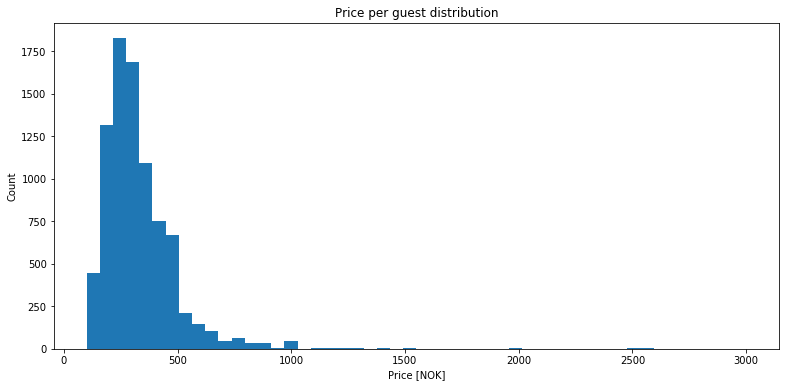

In [124]:
bins = 50
plt.subplots(figsize = [13,6])

plt.hist(df['price_per_guest'], bins = bins)

plt.xlabel("Price [NOK]")
plt.ylabel("Count")

plt.title("Price per guest distribution");

In [122]:
df.price_per_guest.median()

298.0

Looks unimodal with a left-skew. The median price per person is right under NOK 300. And we see it's rare that it's larger than NOK 1000.


Proportions in percent:


,neighbourhood_cleansed
Grünerløkka,22.297613
Gamle Oslo,17.828732
Frogner,16.565278
St. Hanshaugen,12.950398
Sagene,11.137108
Nordstrand,3.299017
Nordre Aker,3.065044
Vestre Aker,2.760880
Ullern,2.222742
Østensjø,1.941975


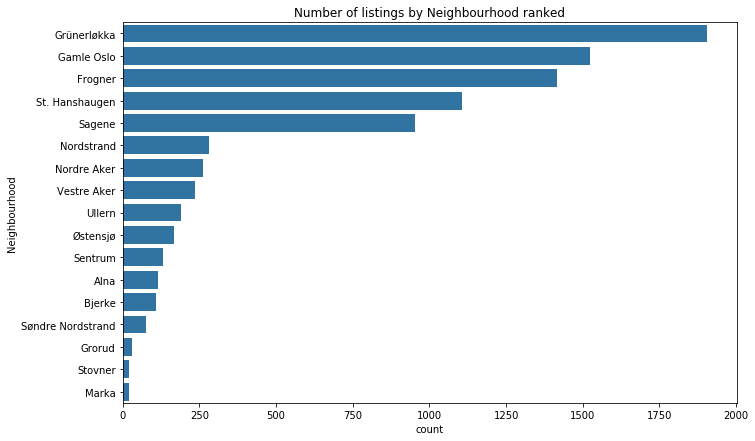

In [125]:
plt.subplots(figsize = [11,7])

sns.countplot(data = df, y = 'neighbourhood_cleansed', color = base_color, 
              order = df['neighbourhood_cleansed'].value_counts().index)

plt.ylabel('Neighbourhood')

plt.title("Number of listings by Neighbourhood ranked");

print('\nProportions in percent:')
pd.DataFrame(100*df['neighbourhood_cleansed'].value_counts()/df['neighbourhood_cleansed'].value_counts().sum())

We see that the top five neighbourhoods when it comes to number of listings represent the bulk of the market with around 81 percent.

So, the bottom twelve neighbourhoods only represent 19 percent.

Let us look at only top ten to see it more clearly.

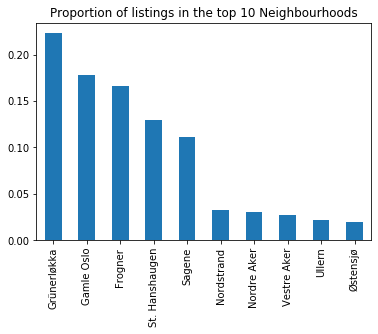

In [126]:
count_vals = pd.Series(df['neighbourhood_cleansed'].value_counts())

(count_vals[:10]/df.shape[0]).plot(kind="bar");
plt.title("Proportion of listings in the top 10 Neighbourhoods");

Let's look at the 'bathrooms' distribution.


Proportions in percent:


,bathrooms
1.0,87.852545
1.5,5.699239
2.0,4.833236
2.5,0.947923
0.5,0.222352
0.0,0.198947
3.0,0.128730
4.0,0.035108
4.5,0.023406
3.5,0.023406


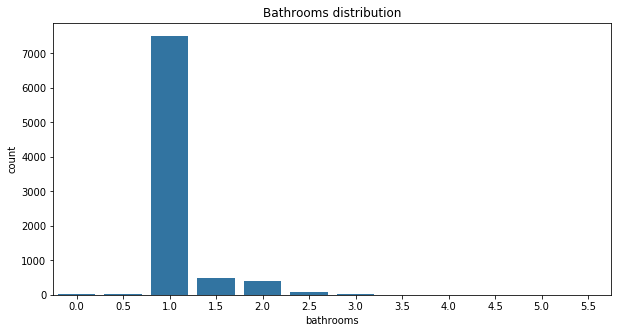

In [130]:
plt.subplots(figsize = [10,5])

sns.countplot(data = df, x = 'bathrooms', color = base_color);

plt.title("Bathrooms distribution");

print('\nProportions in percent:')
pd.DataFrame(100*df['bathrooms'].value_counts()/df['bathrooms'].value_counts().sum())

Only 1 bathroom is really common with 88 percent.

What about bedrooms?


Proportions in percent:


,bedrooms
1.0,57.988997
2.0,24.394241
0.0,7.386164
3.0,7.280815
4.0,2.317687
5.0,0.515042
6.0,0.058527
8.0,0.023411
7.0,0.023411
9.0,0.011705


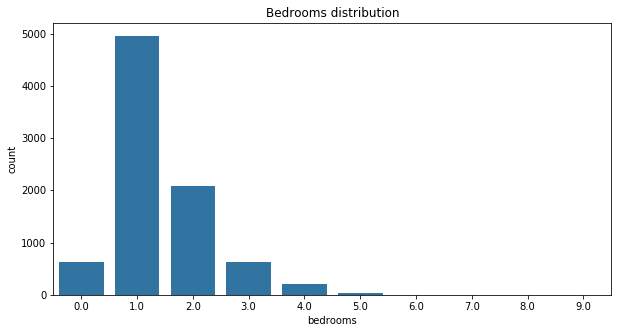

In [129]:
plt.subplots(figsize = [10,5])

sns.countplot(data = df, x = 'bedrooms', color = base_color);

plt.title("Bedrooms distribution");

print('\nProportions in percent:')
pd.DataFrame(100*df['bedrooms'].value_counts()/df['bedrooms'].value_counts().sum())

Almost 60 percent of listings have 1 bedroom. However, it's clear that there are many listings with multiple bedrooms and still only one bathroom.

In [136]:
df[(df['bathrooms'] == 1) & (df['bedrooms'] > 1)]['id'].count()/df.shape[0]

0.2594759007955077

Around 26 percent have multiple bedrooms, but only one bathroom.

How common are superhosts?


Proportions in percent:


,host_is_superhost
0.0,87.401944
1.0,12.598056


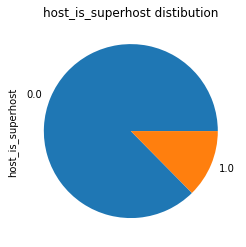

In [137]:
ax = df['host_is_superhost'].value_counts().plot(kind='pie')
ax.set_title('host_is_superhost distibution')

print('\nProportions in percent:')
pd.DataFrame(100*df['host_is_superhost'].value_counts()/df['host_is_superhost'].value_counts().sum())

So, 12.6 percent of listings have a host that's a superhost.

How about the number of people accommodated?


Proportions in percent:


,accommodates
2,38.500234
4,23.561067
3,15.477305
5,6.691624
6,5.954609
1,5.779130
8,1.649509
7,1.520824
9,0.386055
10,0.257370


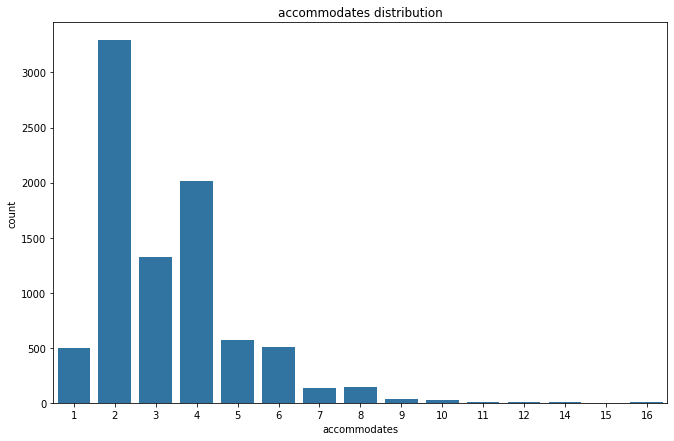

In [138]:
plt.subplots(figsize = [11,7])

sns.countplot(data = df, x = 'accommodates', color = base_color);

plt.title("accommodates distribution");

print('\nProportions in percent:')
pd.DataFrame(100*df['accommodates'].value_counts()/df['accommodates'].value_counts().sum())

It's rare that it is possible to accommodate only one person. 

For most hosts it is quite easy to fit a double bed, probably.

Let's also have a look at the average prices based on how many are accommodated.

In [149]:
unique_accommodates_values = list(df.accommodates.value_counts().index.sort_values())

df.groupby('accommodates')['price_full'].mean()/unique_accommodates_values

accommodates
1     461.091093
2     354.309784
3     302.622575
4     299.808342
5     286.652098
6     318.577931
7     274.805495
8     295.059397
9     287.602694
10    290.536364
11    287.560606
12    365.472222
14    313.500000
15    299.800000
16    585.395833
Name: price_full, dtype: float64

Naturally it gets more expensive for one person than for multiple persons, like it also would in a hotel.

Let's look at some attributes of the 'extra_people' column.

In [143]:
df.extra_people.value_counts()

0.0       4651
100.0      786
200.0      763
150.0      497
300.0      298
250.0      279
500.0      155
50.0       154
400.0      113
350.0       59
120.0       29
151.0       26
75.0        26
101.0       26
199.0       25
202.0       25
180.0       22
450.0       19
252.0       18
183.0       18
600.0       17
80.0        17
125.0       16
140.0       15
170.0       15
175.0       15
275.0       14
1000.0      14
149.0       14
190.0       14
99.0        14
229.0       13
130.0       13
299.0       13
90.0        13
303.0       12
110.0       12
92.0        10
70.0        10
160.0        8
353.0        8
95.0         8
290.0        7
60.0         7
230.0        7
138.0        7
49.0         6
145.0        6
195.0        6
165.0        5
459.0        5
135.0        5
225.0        5
46.0         5
270.0        5
404.0        5
119.0        4
900.0        4
505.0        4
249.0        4
240.0        4
700.0        4
390.0        3
121.0        3
102.0        3
131.0        3
111.0     

In [144]:
df[df.beds/df.accommodates < 0.5].T

,1,2,4,12,16,20,28,31,43,56,57,58,61,75,77,96,100,110,120,131,141,145,155,157,163,178,181,192,198,203,205,208,213,221,230,232,233,236,239,252,258,272,274,277,279,280,282,297,300,313,...,8310,8314,8319,8320,8321,8328,8332,8333,8340,8352,8366,8368,8379,8387,8396,8402,8408,8410,8417,8419,8421,8424,8458,8477,8479,8497,8508,8511,8514,8520,8524,8525,8542,8543,8544,8546,8549,8552,8555,8558,8562,8565,8576,8577,8578,8581,8583,8585,8592,8596
id,43198,69964,77108,174372,213353,287915,413431,444639,584874,707856,708213,749061,760572,927847,960057,1180211,1226982,1306517,1482144,1570019,1621186,1648688,1748619,1758800,1808457,1944730,1969573,2056067,2118966,2148651,2169158,2175783,2225033,2297030,2365384,2382287,2382708,2430967,2455352,2588091,2659978,2821297,2851475,2854114,2876842,2881012,2890760,2964243,2967558,3020093,...,39106368,39124775,39148580,39163679,39164393,39199714,39249400,39249542,39286412,39361562,39413753,39415071,39457133,39478321,39519749,39551969,39570876,39571909,39595494,39597102,39599345,39622761,39810136,39914549,39920900,40017492,40080655,40090230,40103046,40125385,40149745,40151533,40228257,40228284,40228530,40255757,40275658,40281926,40286426,40300963,40318133,40320370,40357748,40370344,40372830,40395753,40403407,40410152,40416610,40423401
space,"A beautiful intimate bedroom, in an appartment...","Warm, modern flat (410 square feet) in quiet a...",The apartment is located on a quiet corner of ...,"Delicate, spacious and light brand new apartme...",Quaint and cosy neighborhood only a 12-minute ...,Hi! I'd like you to have the oportunity to lo...,"A lovely, classic and modern haven in a quiet ...","I love quietness, same as lively and cozy spac...",My apartment is located in the super nice and ...,Whether you are in Oslo for business or pleasu...,"The cozy ""marshmellow-flat"", which got its nam...","The apartment has a fully equiped kitchen, wi-...",*Please contact me to check additional availab...,#tallpeoplefriendly #comfortable #modern #quie...,"Sørenga is a new and developing area in Oslo, ...",Planning a holiday/stay in Oslo this summer? Y...,Apartment in the center of Oslo. New building ...,A charming and light apartment in a quiet squa...,You have your own room. Where two people can s...,Bright and newly renovated 75 m2 apartement in...,The apartment is 72 m2 and located on the firs...,Send me an inbox before you make your reservat...,"Modern, centrally located 45 m2 apartment. 1 b...",•• PLEASE NOTE: This listing is for a private ...,Quiet and cosy but still walking distance from...,"You have your own quiet, private bedroom with ...",The apartment is unique because it is very bea...,"Nice, central flat with spectacular views. 1 b...",A nice and simple two room apartment with an o...,The appartement is situated in a charming and ...,The apartment is totally renovated in 2017. Th...,"Light, cozy apartment of 45 square metres is l...","Compact but extremely well designed, feels spa...",The apartment is equipped with all amenities a...,This is the apartment for those who want a cen...,I have a big double bed and an extra bed I can...,Welcome to my place in Oslo. It hopefully has ...,"The apartment has a nordic, white and minimali...",75 sq m 10th floor apartment in central Oslo l...,Bright and comfortable 45 m2 flat with all nec...,NaN,"THE APARTMENTs bedroom, kitchen and bathroom h...",Easy parking Wifi Espressomachine microwave Ba...,"My apartement is 51 suare meters with a big, s...",NaN,The flat is on the Fifth floor. It includes tw...,"Quiet area, just outside of the downtown core....",Welcome to our apartment located at the lower ...,Ideal for a couple with a friend or three good...,Located just above fashionable Grunnerløkka is...,...,Outstanding apartment close to the woods. 15 m...,The apartment is my home when not rented out. ...,You can pick up the keys at Coop extra superma...,NaN,"Spacious living room with lounge area, kitchen...","Large 3 bedroom apartment, 4th floor with nice...",The apartment 

It seems like there is some inconsistencies connected to 'accommodates', 'guest_included' and 'extra_people'. For instance, listing 77108 (third column above) where accommodates is 8 and guest_included is 6, but the price for extra_people is 0. Isn't then 8 guests actually included??

The display of 'accommodates' is more visible on the website, so I guess most hosts would make sure this data is correct. However, the advantage with using 'guest_included' instead is that you can use the original 'price' data, without having to add up for extra people.

UPDATE: Based on this observation an extra cleaning step was added resulting in a new column 'price_full'. The big benefit is that it allows us to use 'accommodates' as a predictor for 'price_full'.


Proportions in percent:


,minimum_nights
2,33.937763
1,23.958821
3,17.641554
4,6.948994
5,6.270473
7,4.199813
6,1.977071
10,0.994385
30,0.959289
14,0.877398


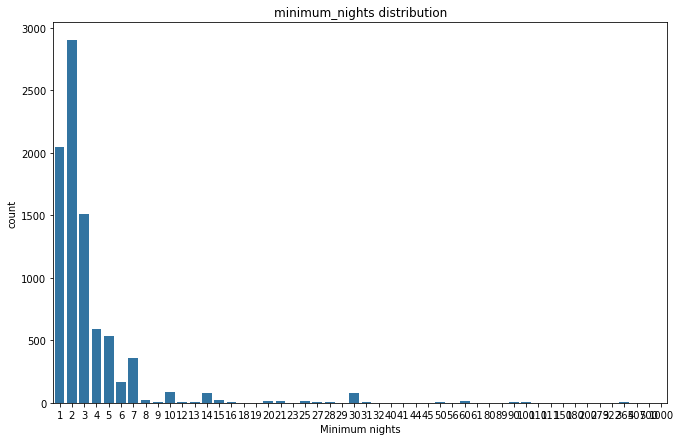

In [145]:
plt.subplots(figsize = [11,7])

sns.countplot(data = df, x = 'minimum_nights', color = base_color);

plt.xlabel("Minimum nights")
plt.title("minimum_nights distribution");

print('\nProportions in percent:')
pd.DataFrame(100*df['minimum_nights'].value_counts()/df['minimum_nights'].value_counts().sum())

The variables 'bathrooms', 'bedrooms' and 'accommodates' are expected to be good predictors. Let's look at a scatter plot.

C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Anaconda3\envs\dand\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


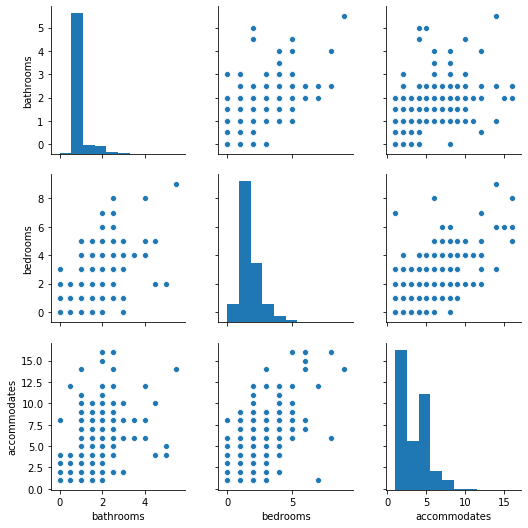

In [146]:
sns.pairplot(df[['bathrooms', 'bedrooms', 'accommodates']]);

Indeed there is positive correlation. A bit hard to read the strength, due to the discrete nature of the data, so let's rather look at a correlation heat map, and we'll throw in the price as well.

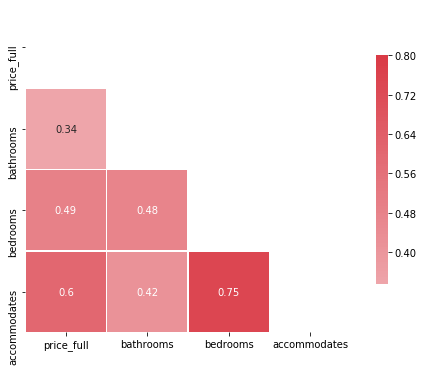

In [148]:
corr = df[['price_full', 'bathrooms', 'bedrooms', 'accommodates']].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .7});

We see all three correlate well with price, especially 'accommodates'. That's good, BUT:

**Might we have covariance issues among the predictors??**

At least the correlation is high between 'bedrooms' and 'accommodates' at 0.74.

In order to investigate this further, we take a look at the VIF scores in the Modeling chapter to see if we can keep them all in our model or not.

Next, we group the `df` data based on neighbourhood, and then pull the mean values into `df_geo` to create a new dataframe `df_geo_full`.

In [150]:
means = pd.DataFrame(df.groupby('neighbourhood_cleansed').mean())

cols_of_interest = ['price_full', 'accommodates', 'host_is_superhost', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
       'review_scores_value', 'bathrooms', 'bedrooms', 'instant_bookable', 'reviews_per_month']

df_grouped = pd.DataFrame(means[cols_of_interest])
df_grouped

,price_full,accommodates,host_is_superhost,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,instant_bookable,reviews_per_month
neighbourhood_cleansed,,,,,,,,,,,,,,,
Alna,700.765217,3.113043,0.104348,11.026087,94.797619,9.654762,9.464286,9.654762,9.750000,9.142857,9.476190,1.069565,1.347826,0.321739,0.961954
Bjerke,755.063636,3.336364,0.072727,10.154545,94.802632,9.684211,9.473684,9.776316,9.789474,9.434211,9.552632,1.081818,1.581818,0.463636,0.929615
Frogner,1185.442797,3.091808,0.146186,22.203390,95.113700,9.700839,9.499534,9.748598,9.804104,9.893358,9.555659,1.107345,1.322034,0.347458,1.211093
Gamle Oslo,1039.841864,3.206693,0.154402,22.541339,95.791930,9.761867,9.530063,9.756735,9.856690,9.590333,9.602219,1.058399,1.349738,0.337270,1.279234
Grorud,724.709677,2.870968,0.161290,9.516129,95.666667,9.777778,9.444444,9.888889,9.851852,9.259259,9.481481,1.050000,1.290323,0.322581,1.063571
Grünerløkka,954.750262,3.107555,0.120336,18.152151,96.071952,9.787333,9.554000,9.776887,9.883923,9.756847,9.638611,1.044596,1.316702,0.325289,1.081043
Marka,1581.800000,5.900000,0.100000,8.000000,96.333333,9.818182,9.333333,9.727273,9.727273,9.545455,9.363636,1.375000,2.350000,0.400000,0.833571
Nordre Aker,1021.683206,3.904580,0.099237,10.988550,95.940860,9.693548,9.586022,9.827957,9.817204,9.537634,9.586022,1.230916,1.904580,0.328244,0.613918
Nordstrand,1261.411348,4.443262,0.163121,17.294326,96.246445,9.800948,9.620853,9.890995,9.919431,9.606635,9.654028,1.296099,2.081560,0.336879,1.053532


In [151]:
g = pd.DataFrame(df_grouped).reset_index(drop=True)

In [152]:
df_geo = df_geo.sort_values('neighbourhood').reset_index(drop=True)

In [153]:
df_geo_full = pd.concat([df_geo, g], axis=1)

In [154]:
df_geo_full['price_per_guest'] = df_geo_full['price_full']/ df_geo_full['accommodates']

In [155]:
df_geo_full.head(3)

,neighbourhood,geometry,price_full,accommodates,host_is_superhost,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,bathrooms,bedrooms,instant_bookable,reviews_per_month,price_per_guest
0,Alna,"MULTIPOLYGON (((10.80798 59.92224, 10.80965 59...",700.765217,3.113043,0.104348,11.026087,94.797619,9.654762,9.464286,9.654762,9.750000,9.142857,9.476190,1.069565,1.347826,0.321739,0.961954,225.106145
1,Bjerke,"MULTIPOLYGON (((10.78661 59.93823, 10.78860 59...",755.063636,3.336364,0.072727,10.154545,94.802632,9.684211,9.473684,9.776316,9.789474,9.434211,9.552632,1.081818,1.581818,0.463636,0.929615,226.313351
2,Frogner,"MULTIPOLYGON (((10.64777 59.90941, 10.67810 59...",1185.442797,3.091808,0.146186,22.203390,95.113700,9.700839,9.499534,9.748598,9.804104,9.893358,9.555659,1.107345,1.322034,0.347458,1.211093,383.414116


Great. We can now easily plot on a map!

Let's test it with 'price_full' as variable

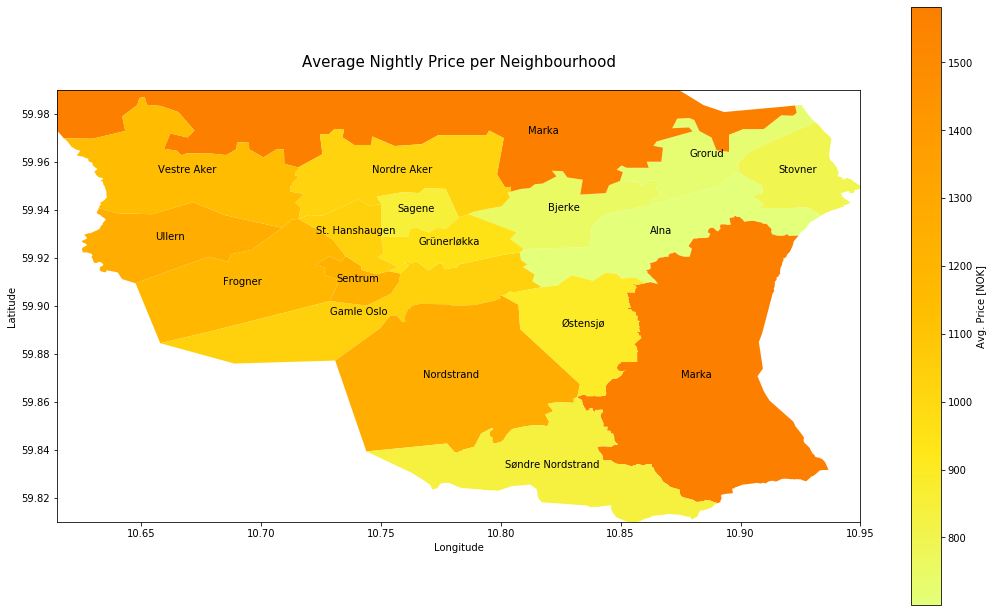

In [157]:
fig, ax = plt.subplots(1, 1, figsize=(18, 11))
ax.set(xlim=(10.615, 10.95), ylim=(59.81, 59.99))

ax.text(10.875, 59.87, 'Marka')

df_geo_full.plot(column='price_full', ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "Avg. Price [NOK]", 
                                                                  'orientation': "vertical"})

plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.xticks([10.7, 10.8, 10.9])
#plt.yticks([59.8, 59.9, 60.0])
plt.suptitle('Marka', y=0.73, fontsize=10)

plt.title('Average Nightly Price per Neighbourhood\n',  fontsize=15);


for idx, row in df_geo.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center')

We see the high price in 'Marka'. However, Marka is the forest around Oslo, and it would typically be larger houses/cabins that can accommodate many guests.

## What data is required to answer our business questions?

Now it's time to pull the data necessary to answer our business questions. 

Questions 1-3 we will answer visually with the help of plots based on descriptive statistics. 

Question 4, however, we will answer in the Modeling chapter, because it requires a model to be fitted before we can look at  key coefficients (predictors of price).

> Question 1: How do Airbnb prices in Oslo vary throughout the year? Any trends / seasonality observed?

To answer the first question we have to use the calendar dataset, or rather `df_merged` which is based on `df_cal`, but has gone through more cleaning steps, in particular the step removing some price outliers.

Any way, it includes the future 1 year calendar data, so based on this we are able to get an estimate of the prices throughout the year. It would have been better to have actual transactions data, of course.

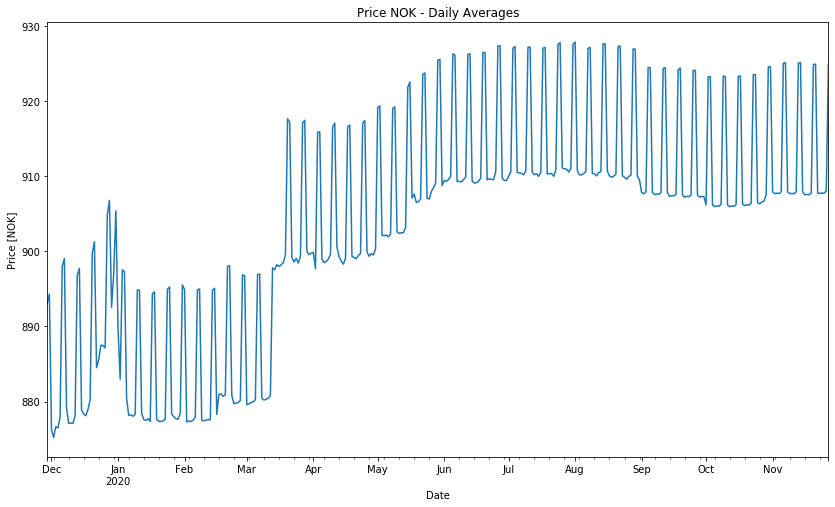

In [219]:
ax = df_merged.groupby('date')['adjusted_price'].mean().plot(figsize = (14, 8), title = 'Price NOK - Daily Averages')

ax.set_xlabel("Date")
ax.set_ylabel("Price [NOK]");

We observe the following trends:

1. Weekend peaks. All the small peaks are two-day weekend peaks at Friday and Saturday.
2. Non-winter peak season. All the way from mid-March through November. However, it's possible that this is not the case, and that it rather is some yearly price adjustment happening, for inflation and/or currency effects. If so the peak season trend could be even weaker than this, only with elevated prices from June-Septemeber if 1-2 percent, which is almost nothing.
3. New year peak. There seems to be a peak around new year.

Note that even if these trends are weak on average, they could be significant on single listings. Not all hosts will be equality diligent in raising prices when demand is high.

> Question 2: Which are the most expensive neighbourhoods, when calculated per guest?

For this question we will use our `df_geo_full` which holds the per-neighbourhood data and will give us some nice plots with geopandas.

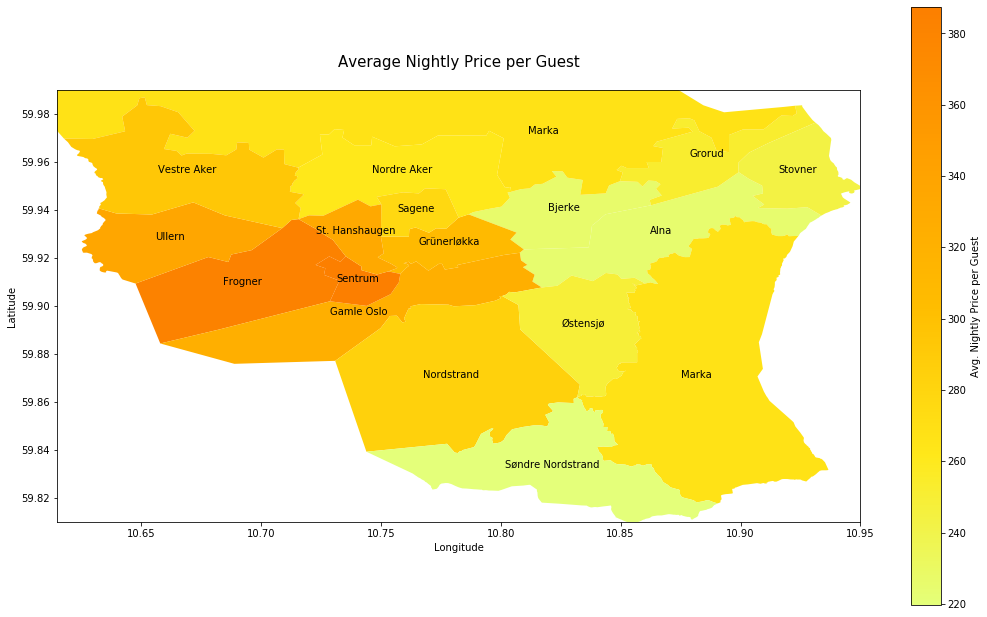

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(18, 11))
ax.set(xlim=(10.615, 10.95), ylim=(59.81, 59.99))

ax.text(10.875, 59.87, 'Marka')

df_geo_full.plot(column='price_per_guest', ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "Avg. Nightly Price per Guest", 
                                                                  'orientation': "vertical"})

plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.xticks([10.7, 10.8, 10.9])
#plt.yticks([59.8, 59.9, 60.0])
plt.suptitle('Marka', y=0.73, fontsize=10)

plt.title('Average Nightly Price per Guest\n',  fontsize=15);


for idx, row in df_geo.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center')

Not surprisingly, Sentrum (city center), is the most expensive. Very convenient, of course.

Followed by Frogner, which is known as the posh part of town.

Not far behind are the popular neighbourhoods of St. Hanshaugen, Gamle Oslo and Grünerløkka.

> Question 3: In which neighbourhoods do guests feel like they got good value for their money?

For this we will use `df_geo_full` again to make a similar visualization for the 'review_scores_value' variable, which is based on ratings submitted by guests.

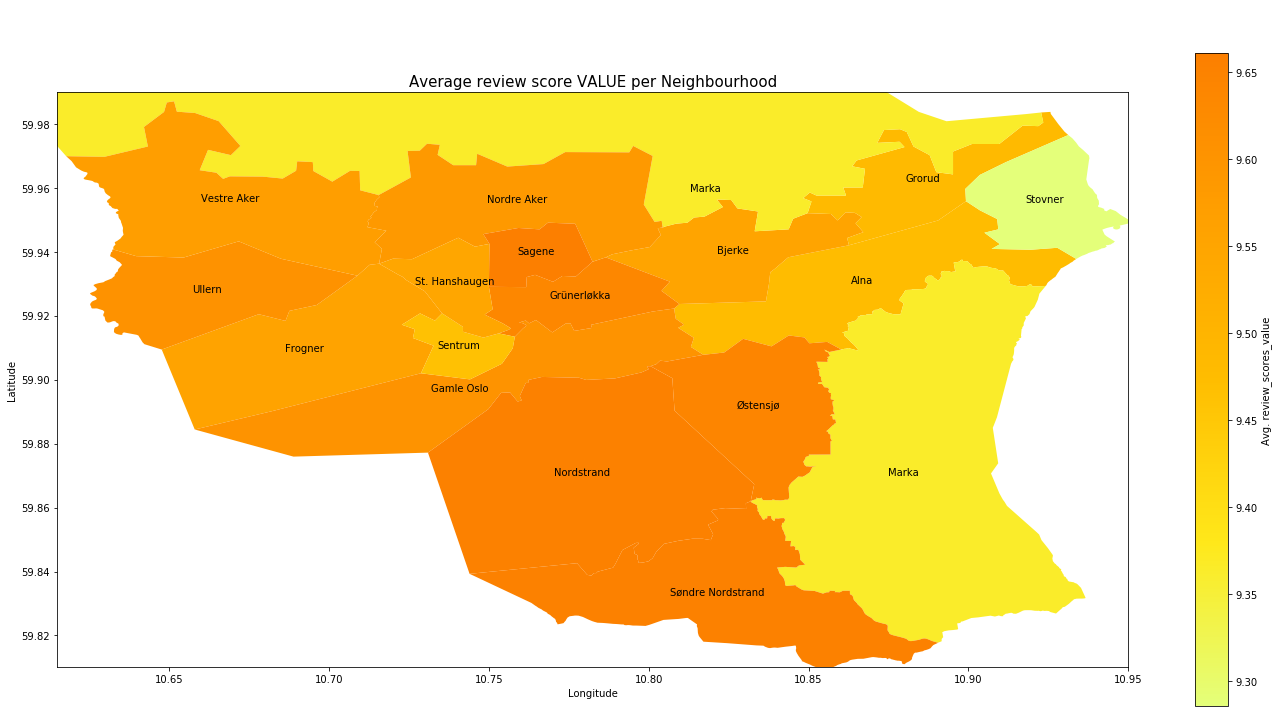

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(24, 12))
ax.set(xlim=(10.615, 10.95), ylim=(59.81, 59.99))

ax.text(10.875, 59.87, 'Marka')

df_geo_full.plot(column='review_scores_value', ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "Avg. review_scores_value", 
                                                                  'orientation': "vertical"})

plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.xticks([10.7, 10.8, 10.9])
#plt.yticks([59.8, 59.9, 60.0])
plt.suptitle('Marka', y=0.73, fontsize=10)

plt.title('Average review score VALUE per Neighbourhood',  fontsize=15);


for idx, row in df_geo.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center')

Good value would indicate that get something good for less money. 

Among the more central neighbourhoods Sagene seems to offer great value. There's also some neighbourhoods in the south-east, Nordstrand, Søndre Nordstrand and Østensjø that offer great value. 

Worst value is Stovner. It's quite far out on the north-east and it will take a long time to reach downtown with public transportation. It seems it isn't enough that the prices are low.

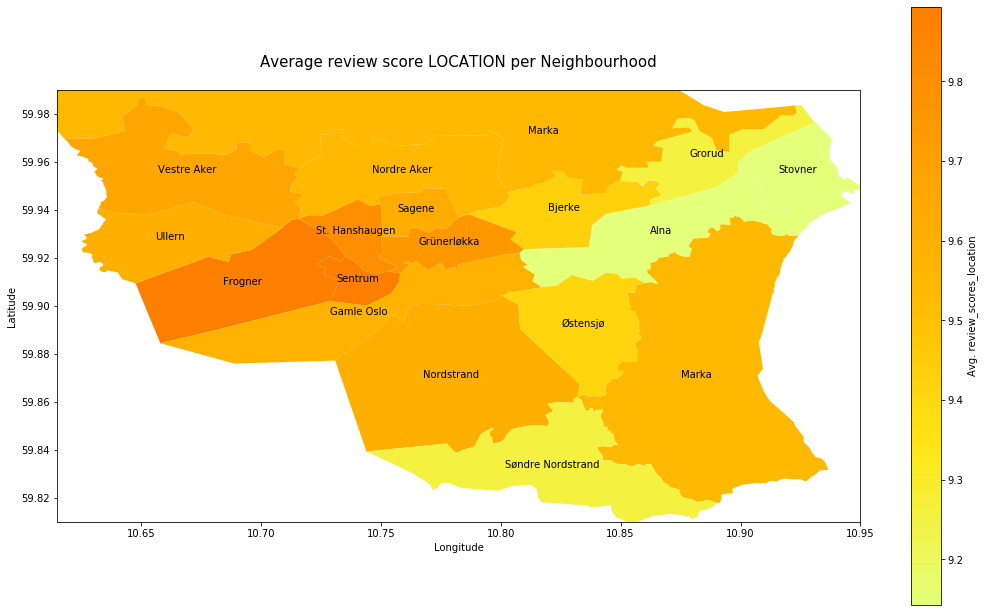

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(18, 11))
ax.set(xlim=(10.615, 10.95), ylim=(59.81, 59.99))

ax.text(10.875, 59.87, 'Marka')

df_geo_full.plot(column='review_scores_location', ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "Avg. review_scores_location", 
                                                                  'orientation': "vertical"})

plt.xlabel("Longitude")
plt.ylabel("Latitude")
#plt.xticks([10.7, 10.8, 10.9])
#plt.yticks([59.8, 59.9, 60.0])
plt.suptitle('Marka', y=0.73, fontsize=10)

plt.title('Average review score LOCATION per Neighbourhood\n',  fontsize=15);


for idx, row in df_geo.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center')

Highly rated as great location we find some of the expensive neighbourhoods we saw earlier, Sentrum and Frogner.

### Modeling

As discovered in the exploration we have high correlation between certain variables.

In order to check for possible covariance issues, we will check the Variance Inflation Factor (VIF) for these variables.

A VIF Factor larger than 10 would indicate that we have issues and need to remove at least one variable.

In [191]:
y2, X2 = dmatrices('price_full ~ bathrooms + bedrooms + accommodates', df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif

,VIF Factor,features
0,14.151245,Intercept
1,1.312153,bathrooms
2,2.440640,bedrooms
3,2.274556,accommodates


Great. All have VIF Factors that are low enough; all below 2.5.

Now we will set up a multivariate linear regression model in order to find the answer to our fourth and final business question

> Question 4: What are the top predictors of price?

The following function will help us prepare the y-vector and X-matrix for the model.

In [192]:
def prepare_variables(df, response_variable):
    '''
    INPUT
    df - pandas dataframe

    OUTPUT
    X - A matrix holding all of the variables to consider when predicting the response
    y - the corresponding response vector

    In order to obtain the correct X and y objects
    this function cleans df using the following steps to produce X and y:
    
    1. Drop all the rows with no data for the 'response_variable'
    2. Create X as all the columns that are not the 'response_variable' column
    3. Create y as the 'response_variable' column
    4. Drop the 'response_variable' column from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    
    # Drop rows with missing price values
    df = df.dropna(subset=[response_variable], axis=0)
    y = df[response_variable]

    #Drop 'response_variable' column
    X = df.drop([response_variable], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = X.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        X[col].fillna((X[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = X.select_dtypes(include=['category']).copy().columns
    for var in cat_vars:
        # for each cat add dummy var, drop original column
        X = pd.concat([X.drop(var, axis=1), pd.get_dummies(X[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

    return X, y

We make a copy of our listings dataframe in order to create a checkpoint, which will be useful to have when we tinker with the variables.

In [206]:
df_mod = df.copy()

We hash out variables/columns that we do not wish to include in our model, 'drop_cols'.

In [207]:
review_exclude = ['review_scores_rating', 'reviews_per_month', 'review_scores_checkin', 
                       'review_scores_communication','review_scores_accuracy', 'review_scores_value', 
                       'review_scores_cleanliness']

lonlat_exclude = ['latbin', 'lonbin', 'latitude', 'longitude']

cat_exclude = ['host_response_time', 'cancellation_policy']

num_exclude = ['id', 'price', 'price_per_guest', 'is_location_exact', 'number_of_reviews', 'number_of_reviews_ltm', 
                    'calculated_host_listings_count', 'security_deposit', 'cleaning_fee', 'guests_included', 
                    'beds', 'extra_people', 'zipcode', 'square_feet', 'host_has_profile_pic']

str_exclude = ['amenities', 'space', 'neighbourhood_cleansed']

amenities_exclude = ['iron']


drop_cols = review_exclude + lonlat_exclude + cat_exclude + num_exclude + amenities_exclude + str_exclude

We drop all columns in the list 'drop_cols'.

In [208]:
df_mod.drop(drop_cols, axis=1, inplace=True)

Now we can prepare our X and y. We will use 'price_full' as our response variable.

In [209]:
X, y = prepare_variables(df_mod, 'price_full')

In [210]:
for col in X.columns:
    if X[col].dtypes == 'uint8':
        X[col] = X[col].astype('int32')

In [211]:
X = X.select_dtypes(include=['float', 'int', 'int32', 'int64'])

In [212]:
def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas series, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=0)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


In [203]:
cutoffs = [2000, 1000, 300, 100]

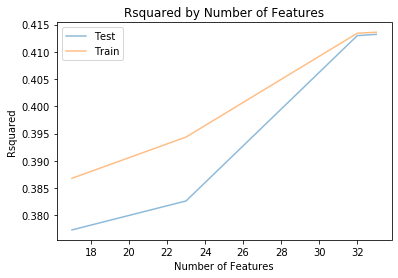

In [213]:
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

With the provided cutoff we get a r-squared of close to 0.412 for both train and test, which means around 40 percent of the price variation is explained by the linear model.

Let's look at the top predictors.

In [224]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
28,grid_sectors_59.9_10.7,313.417360,313.417360
2,bathrooms,303.645975,303.645975
1,accommodates,220.801242,220.801242
29,grid_sectors_59.9_10.725,195.745186,195.745186
30,grid_sectors_59.9_10.75,158.928295,158.928295
8,kitchen,-142.081421,142.081421
23,room_type_Private room,-134.466373,134.466373
25,grid_sectors_59.925_10.725,131.353171,131.353171
24,grid_sectors_59.925_10.7,114.002247,114.002247
20,bbq_grill,112.450309,112.450309


In [223]:
coef_df.head()

,est_int,coefs,abs_coefs
28,grid_sectors_59.9_10.7,313.417360,313.417360
2,bathrooms,303.645975,303.645975
1,accommodates,220.801242,220.801242
29,grid_sectors_59.9_10.725,195.745186,195.745186
30,grid_sectors_59.9_10.75,158.928295,158.928295


Ok, so these are the top five predictors.

Let's have a closer look at those three grid sectors in a map plot.

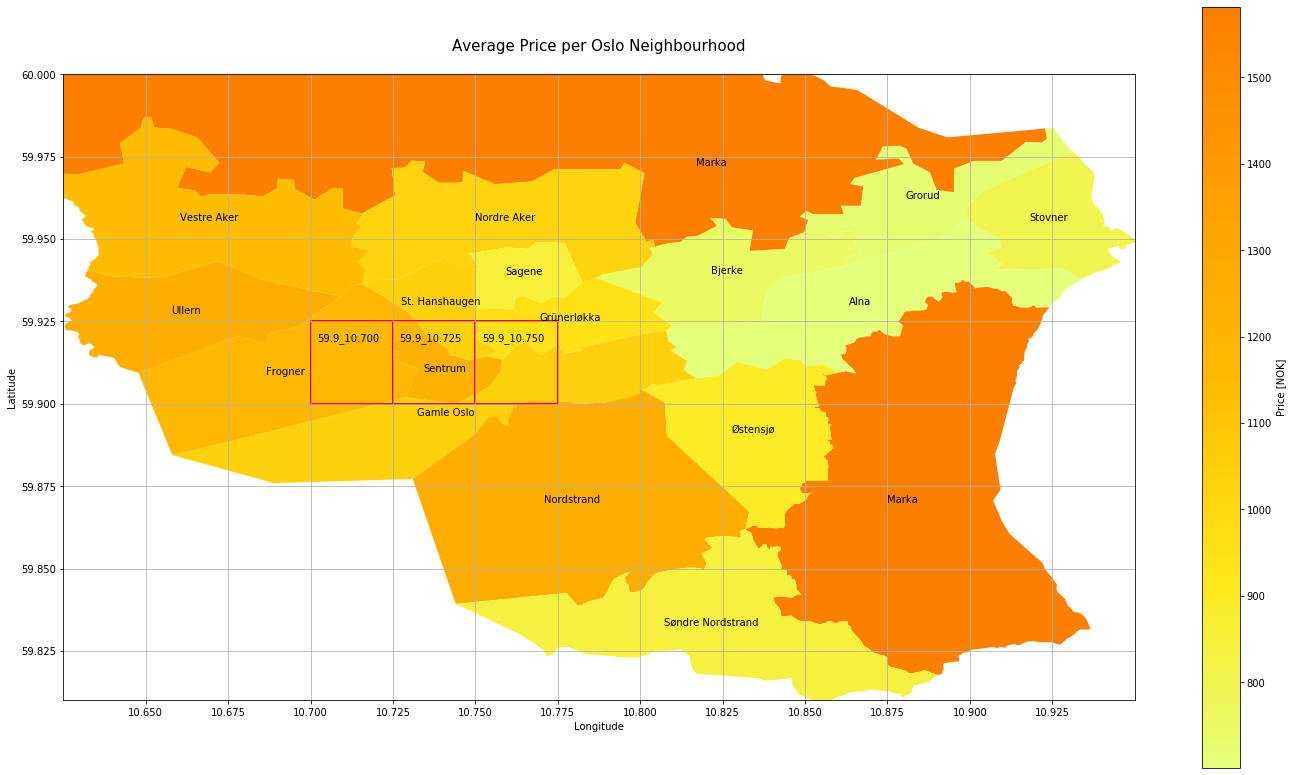

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(24, 14))
ax.set(xlim=(10.625, 10.95), ylim=(59.81, 59.99))

ax.text(10.875, 59.87, 'Marka')
ax.text(10.702, 59.919, '59.9_10.700')
ax.text(10.727, 59.919, '59.9_10.725')
ax.text(10.752, 59.919, '59.9_10.750')


df_geo_full.plot(column='price_full', ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "Price [NOK]", 
                                                                  'orientation': "vertical"})


plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xticks([10.65, 10.675, 10.7, 10.725, 10.75, 10.775, 10.8, 10.825, 10.85, 10.875, 10.9, 10.925])
plt.yticks([59.825, 59.85, 59.875, 59.9, 59.925, 59.95, 59.975, 60.0])
plt.grid()

plt.title('Average Price per Oslo Neighbourhood\n',  fontsize=15)
plt.suptitle('Marka', y=0.73, fontsize=10);

rect1 = patches.Rectangle((10.7,59.9),0.025,0.025,linewidth=2,edgecolor='r',facecolor='none')
rect2 = patches.Rectangle((10.725,59.9),0.025,0.025,linewidth=2,edgecolor='r',facecolor='none')
rect3 = patches.Rectangle((10.75,59.9),0.025,0.025,linewidth=2,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)

for idx, row in df_geo.iterrows():
    plt.annotate(s=row['neighbourhood'], xy=row['geometry'].centroid.coords[0],
                 horizontalalignment='center')

### Evaluation

So the top predictors of price are basically:
- Location (represented by three adjacent grid sectors)
- Roominess (represented by how many people can be accommodated and the number of bathrooms)

### References